In [4]:
import pandas as pd
import numpy as np
import os

from keras.api.utils import Sequence
from keras.api.callbacks import EarlyStopping, ModelCheckpoint
from keras.api.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder


ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

In [ ]:
def load_actuals(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['week_start'])
    df.rename(columns={'week_start': 'date'}, inplace=True)
    return df

def load_competitors(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.rename(columns={'Date': 'date'}, inplace=True)
    return df

def load_residuals(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, header=None, names=['date', 'sarima_residual'])
    df['date'] = pd.to_datetime(df['date'])
    return df

def merge_all_data(actuals: pd.DataFrame, competitors: pd.DataFrame, residuals: pd.DataFrame = None) -> pd.DataFrame:
    df = actuals.merge(competitors, on='date', how='left')
    if residuals is not None:
        df = df.merge(residuals, on='date', how='left')
    return df

def load_and_merge_all_data(folder_path: str) -> pd.DataFrame:
    actuals_path = os.path.join(folder_path, 'Actuals_all_enriched.csv')
    competitors_path = os.path.join(folder_path, 'Competitors.csv')
    residuals_path = os.path.join(folder_path, 'residuals.csv')

    actuals = load_actuals(actuals_path)
    competitors = load_competitors(competitors_path)
    residuals = load_residuals(residuals_path)

    merged_df = merge_all_data(actuals, competitors, residuals)
    return merged_df


In [ ]:
def drop_unnecessary_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_drop = ['Country.Country Name', 'last_renewal_week']
    return df.drop(columns=cols_to_drop, errors='ignore')

def encode_categoricals(df: pd.DataFrame, categorical_columns: list) -> tuple[pd.DataFrame, dict]:
    encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders

def scale_numericals(df: pd.DataFrame, numerical_columns: list) -> tuple[pd.DataFrame, StandardScaler]:
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df, scaler

def preprocess_data(df: pd.DataFrame) -> tuple[pd.DataFrame, dict, StandardScaler]:
    df = drop_unnecessary_columns(df)
    #df = filter_invalid_rows(df)

    categorical_cols = ['Customer.Customer Code', 'item_code', 'Item.Sales Model', 
                        'item_suffix', 'country_code', 'item_suffix_code', 'sales_model_code']
    df, encoders = encode_categoricals(df, categorical_cols)

    excluded_cols = ['date', 'Sum of Invoiced Amount EUR'] + categorical_cols
    numerical_cols = [col for col in df.columns if col not in excluded_cols and df[col].dtype in ['float64', 'int64']]
    df, scaler = scale_numericals(df, numerical_cols)
    # After scaling, drop rows where features have NaN
    df = df.dropna(subset=numerical_cols).reset_index(drop=True)
    return df, encoders, scaler


In [ ]:
class LSTMDataGenerator(Sequence):
    def __init__(self, df, input_window, forecast_horizon, target_col, time_col, batch_size=64, return_dates=False):
        self.df = df.sort_values(time_col).reset_index(drop=True)
        self.input_window = input_window
        self.forecast_horizon = forecast_horizon
        self.target_col = target_col
        self.time_col = time_col
        self.batch_size = batch_size
        self.return_dates = return_dates

        # Select only numeric feature columns
        self.features = self.df.drop(columns=[time_col, target_col])
        self.features = self.features.select_dtypes(include=['float64', 'int64', 'int32', 'float32'])
        self.features = self.features.values

        # Ensure target is float as well
        self.target = self.df[target_col].astype(float).values
        self.dates = self.df[time_col].values if return_dates else None
        self.indexes = np.arange(len(self.df) - input_window - forecast_horizon + 1)

        print("Feature matrix shape:", self.features.shape)
        print("Feature dtypes:", self.df.drop(columns=[time_col, target_col]).dtypes.value_counts())

    def __len__(self):
        return int(np.ceil(len(self.indexes) / self.batch_size))


    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y, dates = [], [], []

        for i in batch_indexes:
            X_seq = self.features[i:i + self.input_window]
            y_seq = self.target[i + self.input_window:i + self.input_window + self.forecast_horizon]
            date = self.df['date'].iloc[i + self.input_window]

            X.append(X_seq)
            y.append(y_seq if self.forecast_horizon > 1 else y_seq[0])
            dates.append(date)

        X_out = np.array(X)
        y_out = np.array(y)
        
        if self.return_dates:
            return X_out, y_out, np.array(dates)
        else:
            return X_out, y_out




In [ ]:
# Example usage:
# Change this notation to your best fitting parameters once Keras tuner would be ran
"""
Best Hyperparameters Found:
lstm_units: 32
dropout: 0.2
lstm_units_2: 128
dropout_2: 0.1
dense_units: 32
learning_rate: 0.0005288480653096841
"""

from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout

#best parameters from your model should be passed into a function or changed as default in function definition
def build_lstm_model(input_shape, units=32, dropout_rate=0.2, units_2=128, dropout_rate_2=0.1, dense_units=32, output_size=1, learning_rate=0.0005):
    model = Sequential()
    
    model.add(LSTM(units,return_sequences=True,input_shape=input_shape    ))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units_2))
    model.add(Dropout(dropout_rate_2))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size))

    model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mae'])
    return model

def build_model(hp, input_shape):
    model = Sequential()
    
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=input_shape
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    return model



def train_lstm_model(model, train_generator, val_generator=None, epochs=10, checkpoint_path="best_model.keras"):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
    ]
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return model, history





KeyboardInterrupt



In [ ]:
def run_data_loading_pipeline():
    folder_path = 'Working_df'
    print("Loading actuals, competitors, and residuals")
    merged_df = load_and_merge_all_data(folder_path)
    print("Data loading complete. Shape:", merged_df.shape)
    return merged_df

def run_preprocessing_pipeline(df: pd.DataFrame):
    print("Preprocessing data")
    processed_df, encoders, scaler = preprocess_data(df)
    print("Preprocessing complete. Shape:", processed_df.shape)

    print("\nColumn dtypes after preprocessing:")
    print(processed_df.dtypes.value_counts())

    print("\nColumns with object dtype:")
    print(processed_df.select_dtypes(include=['object']).head())

    return processed_df, encoders, scaler

def split_train_val(df: pd.DataFrame, val_ratio: float = 0.2):
    split_index = int(len(df) * (1 - val_ratio))
    train_df = df.iloc[:split_index].reset_index(drop=True)
    val_df = df.iloc[split_index:].reset_index(drop=True)
    return train_df, val_df

def run_lstm_training_pipeline(df, input_window=8, forecast_horizon=1, target_col='Sum of Invoiced Amount EUR', batch_size=64):
    print("Starting LSTM training pipeline...")

    # Split the data chronologically into train/validation
    train_df = df[df['date'] < '2023-01-01']
    val_df = df[df['date'] >= '2023-01-01']

    # Create data generators
    train_gen = LSTMDataGenerator(
        train_df,
        input_window=input_window,
        forecast_horizon=forecast_horizon,
        target_col=target_col,
        time_col='date',
        batch_size=batch_size,
        return_dates=False
    )
    val_gen = LSTMDataGenerator(
        val_df,
        input_window=input_window,
        forecast_horizon=forecast_horizon,
        target_col=target_col,
        time_col='date',
        batch_size=batch_size,
        return_dates=False
    )

    # Determine correct input shape from the actual generator
    sample_input_shape = (input_window, train_gen.features.shape[1])
    print(f"LSTM Input Shape: {sample_input_shape}")

    # Build and train the model
    model = build_lstm_model(input_shape=sample_input_shape)

    print("Training model")
    model, history = train_lstm_model(model, train_gen, val_generator=val_gen, epochs=20)

    print("Training complete")
    return model, history, train_gen, val_gen, val_df



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def predict_from_generator(model, generator, n_batches=10):
    y_true, y_pred, dates = [], [], []

    for i in range(n_batches):
        X_batch, y_batch, batch_dates = generator[i]
        y_true.extend(y_batch)
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_pred.extend(y_pred_batch.flatten())
        dates.extend(batch_dates)

    return np.array(y_true), np.array(y_pred), np.array(dates)

def plot_predictions(y_true, y_pred, dates=None, title="Predictions vs Actuals"):
    plt.figure(figsize=(12,6))
    
    if dates is not None:
        plt.plot(dates[:len(y_true)], y_true, label='True')
        plt.plot(dates[:len(y_pred)], y_pred, label='Predicted')
        plt.xticks(rotation=45)
    else:
        plt.plot(y_true, label='True')
        plt.plot(y_pred, label='Predicted')

    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Sample')
    plt.ylabel('Sum of Invoiced Amount EUR')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def print_error_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100 

    print("\nError Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

def signed_exp_transform(x):
    return np.sign(x) * (np.expm1(np.abs(x)))


def evaluate_model(model, generator, n_batches=10):
    y_true_log, y_pred_log, aligned_dates = predict_from_generator(model, generator, n_batches=n_batches)


    y_true = signed_exp_transform(y_true_log)
    y_pred = signed_exp_transform(y_pred_log)

    plot_predictions(y_true, y_pred, dates=aligned_dates)
    print_error_metrics(y_true, y_pred)



In [ ]:
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

def log_transform_target_signed(df: pd.DataFrame, target_col: str = 'Sum of Invoiced Amount EUR') -> pd.DataFrame:
    df[target_col] = signed_log_transform(df[target_col])
    return df


In [ ]:
from keras_tuner import RandomSearch
def best_model_hyperparameters(processed_df, train_gen, val_gen, target_col = 'Sum of Invoiced Amount EUR', input_window = 8):
    target_col = 'Sum of Invoiced Amount EUR'
    exclude_cols = ['date', target_col]
    num_features = processed_df.drop(columns=exclude_cols).shape[1]

    input_shape = (input_window, num_features)

    tuner = RandomSearch(
        hypermodel=lambda hp: build_model(hp, input_shape=input_shape),
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='tuner_dir',
        project_name='lstm_sales'
    )


    tuner.search(train_gen, validation_data=val_gen, epochs=10)
    #best_model = tuner.get_best_models(num_models=1)[0]
    return tuner
    


In [ ]:
def plot_original_sales(df, target_col='Sum of Invoiced Amount EUR', date_col='week_start'):
    df_plot = df.copy()
    
    if date_col not in df_plot.columns:
        raise ValueError(f"Column '{date_col}' not found. Available columns: {df_plot.columns.tolist()}")

    df_plot['date'] = pd.to_datetime(df_plot[date_col])
    weekly_sales = df_plot.groupby('date')[target_col].sum().reset_index()

    plt.figure(figsize=(14,6))
    plt.plot(weekly_sales['date'], weekly_sales[target_col], label='Total Weekly Sales')
    plt.title('Original Total Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:

df = run_data_loading_pipeline()

# Drop final week if it's incomplete
latest_week = df['date'].max()
df = df[df['date'] < latest_week]

processed_df = log_transform_target_signed(df, target_col='Sum of Invoiced Amount EUR')

processed_df, encoders, scaler = run_preprocessing_pipeline(df)

raw_target = processed_df['Sum of Invoiced Amount EUR'].copy()

print("Raw target stats:")
print("Min:", raw_target.min())
print("Max:", raw_target.max())
print("Mean:", raw_target.mean())
print("Sample values:", raw_target.sample(10).tolist())



target = processed_df['Sum of Invoiced Amount EUR']
print("Log-transformed target stats:")
print("Min:", target.min())
print("Max:", target.max())
print("Mean:", target.mean())
print("Sample values:", target.sample(10).tolist())

model, history, train_gen, val_gen, val_df = run_lstm_training_pipeline(processed_df)

val_gen_eval = LSTMDataGenerator(
    val_df,
    input_window=8,
    forecast_horizon=1,
    target_col='Sum of Invoiced Amount EUR',
    time_col='date',
    batch_size=64,
    return_dates=True  # This enables date tracking
)

evaluate_model(model, val_gen_eval, n_batches=10)



Loading actuals, competitors, and residuals


C:\Users\danii\AppData\Local\Temp\ipykernel_19780\1927011152.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['week_start'])


Data loading complete. Shape: (908192, 44)
Preprocessing data


MemoryError: Unable to allocate 228. MiB for an array with shape (907528, 33) and data type float64

In [ ]:
tuner = best_model_hyperparameters(processed_df, train_gen, val_gen, 'Sum of Invoiced Amount EUR', 8)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# Print each best hyperparameter
print("\nBest Hyperparameters Found:")
for hp_name in best_hyperparameters.values.keys():
    print(f"{hp_name}: {best_hyperparameters.get(hp_name)}")



🏆 Best Hyperparameters Found:
lstm_units: 32
dropout: 0.2
lstm_units_2: 128
dropout_2: 0.1
dense_units: 32
learning_rate: 0.0005288480653096841


Additional visualisations

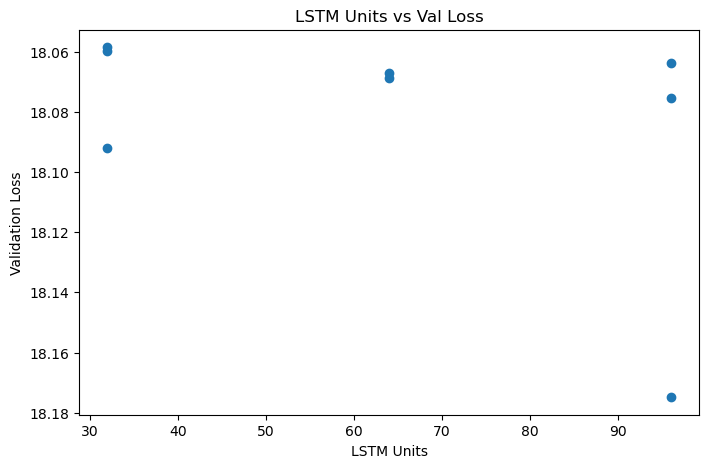

In [ ]:
import matplotlib.pyplot as plt

# Extract all trials
trials = tuner.oracle.get_best_trials(num_trials=10)

val_losses = [trial.score for trial in trials]
lstm_units = [trial.hyperparameters.get('lstm_units') for trial in trials]

plt.figure(figsize=(8,5))
plt.scatter(lstm_units, val_losses)
plt.xlabel('LSTM Units')
plt.ylabel('Validation Loss')
plt.title('LSTM Units vs Val Loss')
plt.gca().invert_yaxis()
plt.show()


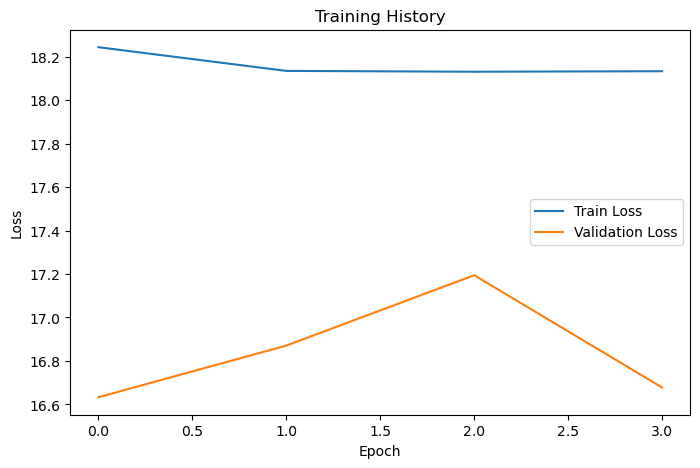

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
plot_training_history(history)


In [ ]:
class LSTMDataGenerator(Sequence):
    def __init__(self, df, input_window, forecast_horizon, target_col, time_col, batch_size=64, return_dates=False):
        self.df = df.sort_values(time_col).reset_index(drop=True)
        self.input_window = input_window
        self.forecast_horizon = forecast_horizon
        self.target_col = target_col
        self.time_col = time_col
        self.batch_size = batch_size
        self.return_dates = return_dates

        # Select only numeric feature columns
        self.features = self.df.drop(columns=[time_col, target_col])
        self.features = self.features.select_dtypes(include=['float64', 'int64', 'int32', 'float32'])
        self.features = self.features.values

        # Ensure target is float as well
        self.target = self.df[target_col].astype(float).values
        self.dates = self.df[time_col].values if return_dates else None
        self.indexes = np.arange(len(self.df) - input_window - forecast_horizon + 1)

        print("Feature matrix shape:", self.features.shape)
        print("Feature dtypes:", self.df.drop(columns=[time_col, target_col]).dtypes.value_counts())

    def __len__(self):
        return int(np.ceil(len(self.indexes) / self.batch_size))


    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y, dates = [], [], []

        for i in batch_indexes:
            X_seq = self.features[i:i + self.input_window]
            y_seq = self.target[i + self.input_window:i + self.input_window + self.forecast_horizon]
            date = self.df['date'].iloc[i + self.input_window]

            X.append(X_seq)
            y.append(y_seq if self.forecast_horizon > 1 else y_seq[0])
            dates.append(date)

        X_out = np.array(X)
        y_out = np.array(y)
        
        if self.return_dates:
            return X_out, y_out, np.array(dates)
        else:
            return X_out, y_out




🔄 Loading actuals, competitors, and residuals...


C:\Users\danii\AppData\Local\Temp\ipykernel_7132\1927011152.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['week_start'])


✅ Data loading complete. Shape: (908192, 44)


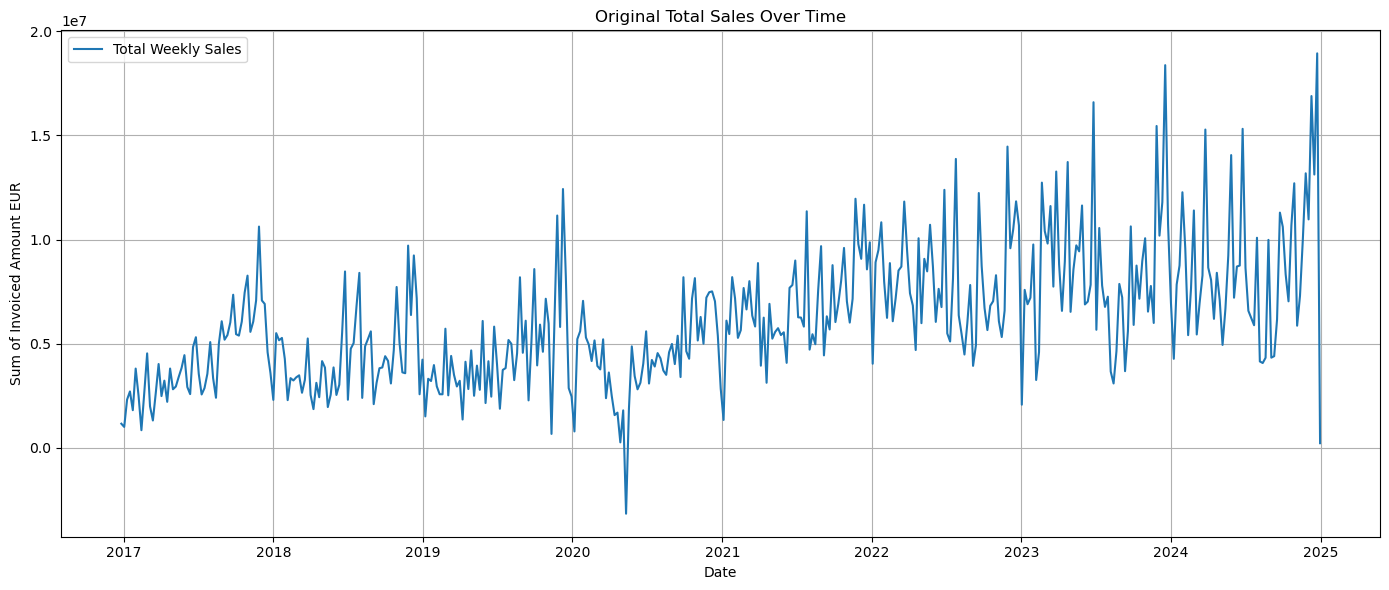

In [ ]:
df = run_data_loading_pipeline()
plot_original_sales(df, target_col='Sum of Invoiced Amount EUR', date_col='date')